In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
from skimage import io 
from skimage.io import imread
cwd = os.getcwd(); os.chdir('../');import rSNAPsim_IP as rss_IP; os.chdir(cwd)
from rSNAPsim_IP_pipelines import simulated_cells_V2 #, simulated_cells_from_ssa_trajectories
from tqdm.notebook import tqdm
# To manipulate arrays
import numpy as np 
import random
import re
from tqdm.notebook import tqdm
import scipy
import pandas as pd
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
from skimage.filters import difference_of_gaussians
from skimage.filters import gaussian
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
from skimage import img_as_float64, img_as_uint

         _____ _   _____    ____           __
   _____/ ___// | / /   |  / __ \___  ____/ /
  / ___/\__ \/  |/ / /| | / /_/ / _ \/ __  / 
 / /   ___/ / /|  / ___ |/ ____/  __/ /_/ /  
/_/   /____/_/ |_/_/  |_/_/    \___/\__,_/   
                                             



In [2]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1  # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 30      # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 2     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient =0.5      # PLEASE TEST MIN 0.1 MAX 2

In [3]:
intensity_selection_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'maximum_area' # options are : 'maximum_spots' and 'maximum_area' 

In [4]:
# running the simulation
ouput_directory_name = simulated_cells_V2(number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None)
path = ouput_directory_name

The results are saved in folder:  ./temp/Simulation_V2__ns_30_diff_0_5/sim_cell_0


In [5]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ ouput_directory_name+'/'+f for f in list_files_names ] # creating the complete path for each file
# Reading the microscopy data
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

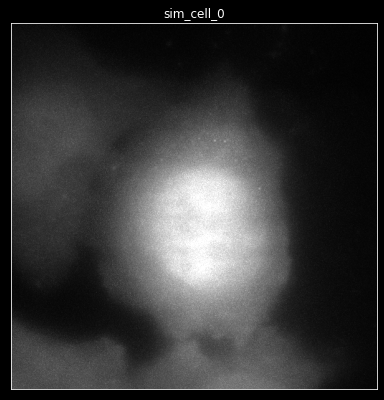

In [6]:
# Showing the simulated images
rss_IP.ImageVisualizer_Multicell(list_videos,list_files_names,selected_channel =1,selected_timepoint= 1,normalize=0,individual_figure_size=7).plot_images()

In [7]:
raise

RuntimeError: No active exception to reraise

In [ ]:
class filters():
    """
      This class allows the user to observe the intensity profile for the detected particles.
      """
    def __init__(self, video,num_cores,low_pass_filter=1, highpass_filters=10,gaussian_filter_sigma=2, selected_channel=0):

        self.num_cores = num_cores
        self.time_points = video.shape[0]
        self.selected_channel = selected_channel
        self.low_pass_filter = low_pass_filter
        self.highpass_filters = highpass_filters
        self.gaussian_filter_sigma = gaussian_filter_sigma
        
        def img_uint(image):
            temp_vid= img_as_uint(image)
            return temp_vid
        init_video = Parallel(n_jobs=self.num_cores)(delayed(img_uint)(video[i,:,:,self.selected_channel]) for i in range(0,self.time_points)) 
        self.video = np.asarray(init_video)
            
    def apply_filter(self):
        def bandpass_filter (image, lowfilter, highpass):
            temp_vid= difference_of_gaussians(image, lowfilter, highpass)
            return img_as_uint(temp_vid)
            #return temp_vid

        def gaussian_filter(image, sigma=0.1):
            temp_image= img_as_float64(image)
            filtered_image = gaussian(temp_image, sigma=sigma, output=None, mode='nearest', cval=0, multichannel=None, preserve_range=True, truncate=4.0)
            #return filtered_image
            return img_as_uint(filtered_image)
        
        temp_vid_dif_filter = Parallel(n_jobs=self.num_cores)(delayed(bandpass_filter)(self.video[i,:,:],self.low_pass_filter,self.highpass_filters) for i in range(0,self.time_points)) 
        array_dif_filter = np.asarray(temp_vid_dif_filter)

        vid_dif_filter = Parallel(n_jobs=self.num_cores)(delayed(gaussian_filter)(array_dif_filter[i,:,:],sigma=self.gaussian_filter_sigma) for i in range(0,self.time_points))                                 
        temp_video_bp_filtered = np.asarray(vid_dif_filter)
        
        return temp_video_bp_filtered


In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(list_videos[0][0,:,:,1],cmap='gray')
plt.show()

In [ ]:
temp_video_bp_filtered = filters(list_videos[0],num_cores,low_pass_filter=0, highpass_filters=2,gaussian_filter_sigma=0.5).apply_filter()
plt.figure(figsize=(12,12))
plt.imshow(temp_video_bp_filtered[0,:,:],cmap='gray')
plt.show()

In [ ]:
temp_video_bp_filtered = filters(list_videos[0],num_cores,low_pass_filter=0.1, highpass_filters=100,gaussian_filter_sigma=0.1).apply_filter()
plt.figure(figsize=(12,12))
plt.imshow(temp_video_bp_filtered[0,:,:],cmap='gray')
plt.show()